# Cartoon Faces Model Evaluation

In [1]:
import torch
import logging
import numpy as np


from aicraft.utils.loaders import CartoonFacesLoader
from aicraft.models.vae.faces.model import FaceVAE
from aicraft.utils.visualise import Visualisations
from matplotlib import pyplot as plt

logger = logging.getLogger(__name__)

if torch.cuda.is_available():
    logger.info("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    logger.info("Using MPS")
    device = torch.device("mps")
else:
    logger.info("Using CPU")
    device = torch.device("cpu")

device

INFO:__main__:Using MPS


device(type='mps')

## Load Data

In [2]:
data_loader = CartoonFacesLoader()
train_loader, val_loader, test_loader = data_loader.get_loaders(batch_size=64)
_batch, _labels = next(iter(test_loader))

INFO:aicraft.utils.loaders:Using provided means and stds for the cartoon faces dataset...
INFO:aicraft.utils.loaders:
means: [0.924, 0.884, 0.854]
stds: [0.181, 0.23, 0.276]


## Load Model

In [3]:
faceVAE = FaceVAE(embedding_size=512)
faceVAE.load("../model-artefacts/face-vae-512-e40.safetensors")
faceVAE.to(device)

FaceVAE(
  (encoder): Encoder(
    (block1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (block2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (block3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (block4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )


## Test Model

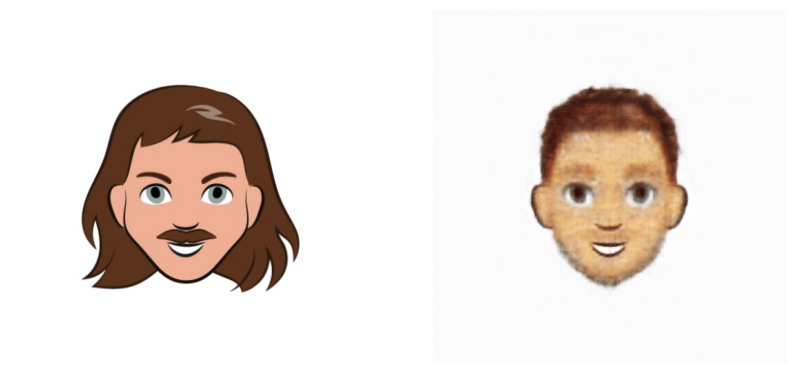

In [4]:
# Running Inference
index = 20
mu, sigma, _batch_reconstructed = faceVAE(_batch.to(device))
_original: torch.Tensor =_batch[index]
_reconstructed: torch.Tensor = _batch_reconstructed[index]
Visualisations.plot_3_channel_images_to_compare(_original, _reconstructed)

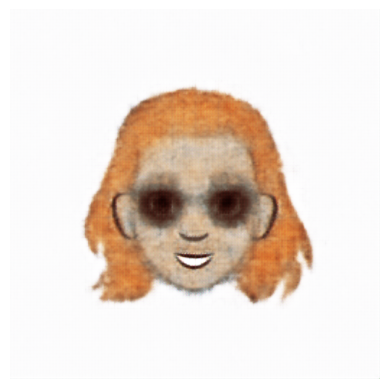

In [5]:
_i = np.random.randint(0, _batch.shape[0])
z = faceVAE.sampling(mu[_i], sigma[_i])
Visualisations.show_3_channel_image(faceVAE.decoder(z).squeeze())

## Morphing Between Faces

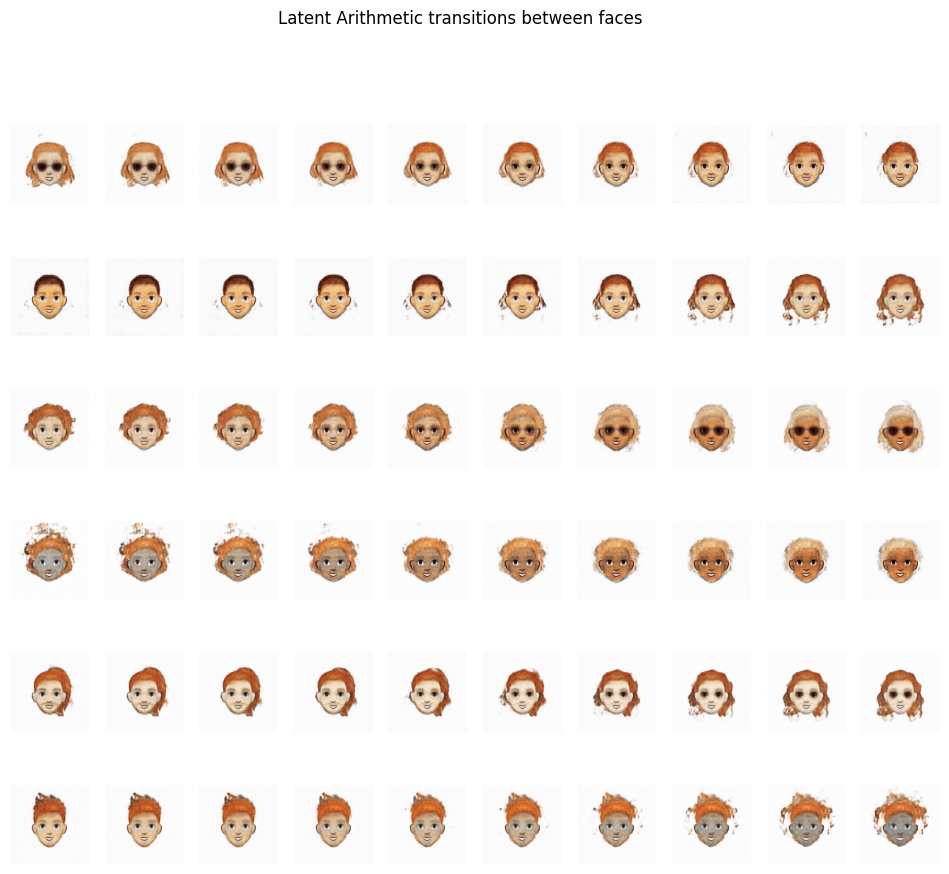

In [6]:
plt.figure(figsize=(12, 10))
plt.suptitle("Latent Arithmetic transitions between faces")
no_of_sequences = 6
for r in range(no_of_sequences):
    _a = np.random.randint(0, _batch.shape[0])
    _b = np.random.randint(0, _batch.shape[0])
    _mu = torch.stack([mu[_a], mu[_b]])
    _sigma = torch.stack([sigma[_a], sigma[_b]])
    Z = faceVAE.sampling(_mu, _sigma)
    _za, _zb = Z[0], Z[1]
    
    
    for i in range(10):
        alpha = i/10
        _zn = _za * (1- alpha) + _zb * alpha
        img = faceVAE.decoder(_zn).squeeze()
        img = img.permute(1, 2, 0)
        img = torch.clamp(img, 0, 1)
        img = img.cpu().squeeze().detach().numpy()
    
        plt.subplot(no_of_sequences, 10, (i+1) + (r*10))
        plt.imshow(img)
        plt.axis("off")
        
plt.show()

## Generating Embeddings

In [7]:
# Generating Embeddings and reconstructing images
z, l, mu, sigma = faceVAE.generate_embedding(test_loader, device)
_test_reconstructed_from_sample = faceVAE.decoder(z)

RuntimeError: MPS backend out of memory (MPS allocated: 81.29 GB, other allocations: 260.09 MB, max allowed: 81.60 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
Visualisations.show_3_channel_image(_test_reconstructed_from_sample)